#### Introduction

In this notebook, we will predict housing prices on a Kaggle dataset using Gradient Boosted Regression Trees. The dataset and model were selected to showcases a number of relevant machine learning techniques all in one project.

Covered in this notebook will be:
* Data cleaning
* How to deal with mixed data types (ints, floats, categorical, etc)
* Gradient Boosted Regression Trees
    * Regression Trees
    * Ensemble Methods
    * Bagging
    * Boosting
* Grid Search
* Cross Validation
* Validation Performance

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.metrics import root_mean_squared_error, make_scorer, r2_score
import matplotlib.pyplot as plt

pd.set_option('future.no_silent_downcasting', True)

In [2]:
# This dataset was obtained from Kaggle. The output is formatted for submisssion to the Kaggle competition.
# Anna Montoya, DataCanary. (2016). House Prices - Advanced Regression
# Techniques. Kaggle.
# https://kaggle.com/competitions/house-prices-advanced-regression-techniques

# Set the path to inputs and outputs
# Note: The data is hosted by Kaggle (as of 11/01/24), and you can follow the link to download it.
#   The csv's have the same name on Kaggle as I use here
PATH_TO_HOUSE_TRAIN = "./data/house_prices/train.csv"
PATH_TO_HOUSE_TEST  = "./data/house_prices/test.csv"
SAVE_DIR = "./results/housing"
SAVE_VIS = False # save visualizations of results
CREATE_OUTPUT_FILE = False # save the test data to a csv for submission

# Create the output path
if SAVE_VIS or CREATE_OUTPUT_FILE:
    os.makedirs(SAVE_DIR, exist_ok=True)

#### Data Cleaning
Before processing, we need to clean the data
* Any missing entries need to be populated with some value (usually mode)
* For most categorical features, some categories are rarely observed. We can combine a rarely observed categories with some other similar category
* Entries that don't make sense need to be fixed.
* Any ordinal data needs to be converted to integers (Poor, Fair, Good, Great can be 1, 2, 3, 4)
* Any categorical data that is not of object type needs to be converted to the object type and vice versa. Ex: MSSubClass is read as an int, but that each int corresponds to a category, and those categories are not ordinal.
* Any categorical data needs to be converted into one-hot vectors and merged with our dataset to be processed by sklearn GradientBoostingRegressor.

These kinds of issues and errors are unfortunately all too common. It's common for required data to be missing or wrong, and to have to use a data wrangling tool to find and remedy the issues. Normally, I'd want to consult a SME (Subject Matter Expert) to better clean the data - especially for missing data or where I combine similar categories. Additionally, SMEs would be able to guide the feature engineering process.

I did my best to determine what categories within a feature did and did not make sense to combine. I'm sure if I dug deeper, and especially if I spoke with an SME then I'd find more anomalies. I'm also sure I made sub-optimal choices in cleaning the data. However, this is an exercise in machine learning, not in real estate.

Note: The cleaning function was written to be readable, not to be fast. This represents a first draft or proof of concept before a more optimized function would be written.

In [3]:
def house_data_fill_in(input_data: pd.DataFrame):
    data = input_data.copy()

    # We can begin by dropping columns that have too many missing values in the training data
    # Frontage: Presumably, houses with NaN for lot frontage have 0 lot frontage. However, the documentation doesn't
    #   confirm this, and it should be 0 if that was the case. There does not seem to be an easy relation between NaNs
    #   and other giveaways like such as being agricultural land or an apartment which could also confirm that theory.
    #   With ~1/6 of the data having NaN for LotFrontage, I decided to simply drop this feature for now.
    # Utilities: Only 1 example in the training data that is not "AllPub". Doesn't make sense to train on 1 example
    # Street: Similarly, there are only 5 examples that aren't "Grvl"
    # RoofStyle: Several categories with too few examples, and seemingly no way to combine them well
    # RoofMatl: 98% was one category, the other 7 categories split that 2%
    # PoolQC: I've opted to turn the pool features into a boolean for pool and no pool
    # Id: ID is the Id assigned by Kaggle. It isn't predictive, and if it is (shame on them), it shouldn't be used
    data.drop(["Id", "LotFrontage", "Utilities", "Street", "RoofStyle", "RoofMatl", "PoolQC"], axis=1, inplace=True)

    # The training and test data both had some NaN values which should be allowed to be NaN. We don't have that many
    #   examples in the training, and we can't drop examples from the test. So for both, we will use the mode value
    #   in the training data.
    # The values are hard coded for simplicity because we would have to use the training modes at test time. If this was
    #   not a demo, all fill values would be in some kind of config file passed to the test preprocessing
    data["Functional"] = data["Functional"].fillna("Typ")
    data["KitchenQual"] = data["KitchenQual"].fillna("TA")
    data["Electrical"] = data["Electrical"].fillna("SBrkr")
    data["SaleType"] = data["SaleType"].fillna("WD")

    # There's some entries (especially important in the test data) where 4/5 basement features indicate a basement but
    #   one of the features is NaN. In those cases, we set the value of that feature to the average
    basement_features1 = ["BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2"]
    basement_fill_ins1 = ["TA",       "TA",       "No",           "Unf",          "Unf"]
    basement_sum = data[basement_features1].isnull().sum(axis=1)
    basement_invalid = (basement_sum != 5) & (basement_sum != 0)
    for basement_feature, basement_fill_in in zip(basement_features1, basement_fill_ins1):
        data.loc[basement_invalid & pd.isna(data[basement_feature]), basement_feature] = basement_fill_in

    # Similarly for the garage features, either all need to be NaN or none should be NaN
    garage_features = ["GarageFinish", "GarageQual", "GarageCond"]
    garage_fill_ins = ["Unf",           "TA",        "TA"]
    garage_sum = data[garage_features].isnull().sum(axis=1)
    garage_invalid = (garage_sum != 3) & (garage_sum != 0)
    for garage_feature, garage_fill_in in zip(garage_features, garage_fill_ins):
        data.loc[garage_invalid & pd.isna(data[garage_feature]), garage_feature] = garage_fill_in

    # Any missing values here should be set to 0
    other_features = ["BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", "BsmtFullBath", "BsmtHalfBath",
                      "GarageCars", "GarageArea"]
    for other_features in other_features:
        data[other_features] = data[other_features].fillna(0.0)

    # For the following features, there were several categories that had too few values to use for training. The concern
    #   is that the model will overfit on the relatively few examples. There's no hard cutoff. I tried to group similar
    #   categories together if one category had less than ~20 items. However, there were exceptions where there was not
    #   a similar category to combine into

    # MSSubClass: Combine 20 (1-Story 1946 & Newer) and 40 (1 Story W/finished Attic All Ages)
    #   Combine 45 (1-1/2 Story Unfinished) and 50 (1-1/2 Story Finished)
    #   Combine 75 (2-1/2 Story All Ages), 80 (Split or Multi-Level), and 85 (Split Foyer)
    #   Combine 120 (1-Story PUD (Planned Unit Development)) and 150 (1-1/2 Story PUD)
    #   Combine 160 (2-Story PUD) and 180 (Multi-Level PUD) 
    data.loc[data["MSSubClass"] == 40, "MSSubClass"] = 20
    data.loc[data["MSSubClass"] == 45, "MSSubClass"] = 50
    data.loc[data["MSSubClass"] == 75, "MSSubClass"] = 80
    data.loc[data["MSSubClass"] == 85, "MSSubClass"] = 80
    data.loc[data["MSSubClass"] == 120, "MSSubClass"] = 150
    data.loc[data["MSSubClass"] == 160, "MSSubClass"] = 180

    # MSZoning: I (Industrial), C (Commercial), and A (Agricultural) can all be combined into one category: Other
    # RH (Residential  High Density) is close to RM (Residential Medium Density)
    # RP (Residential Low Density Park) is close to RL (Residential Low Density)
    data.loc[data["MSZoning"] == "A", "MSZoning"] = "Other"
    data.loc[data["MSZoning"] == "C", "MSZoning"] = "Other"
    data.loc[data["MSZoning"] == "I", "MSZoning"] = "Other"
    data.loc[data["MSZoning"] == "C (all)", "MSZoning"] = "Other"
    data.loc[data["MSZoning"] == "RH", "MSZoning"] = "RM"
    data.loc[data["MSZoning"] == "RP", "MSZoning"] = "RL"

    # LotShape: IR3 (Irregular) is close to IR2 (Moderately Irregular)
    data.loc[data["LotShape"] == "IR3", "LotShape"] = "IR2" 

    # LotConfig: FR3 (Frontage on 3 sides of property) is close to FR2 (Frontage on 2 sides of property)
    data.loc[data["LotConfig"] == "FR3", "LotConfig"] = "FR2" 

    # LandSlope: Sev (Severe) is close to Mod (Moderate)
    data.loc[data["LandSlope"] == "Sev", "LandSlope"] = "Mod" 

    # Neighborhood: There are several neighborhoods with too few examples. Ideally, I'd combine them with a similar
    #   neighborhood using distance between the neighborhoods and sale price as a heuristic. But for this short
    #   demonstration, I'm just going to set all those neighborhoods to "Other"
    data.loc[data["Neighborhood"] == "Blueste", "Neighborhood"] = "Other" 
    data.loc[data["Neighborhood"] == "NPkVill", "Neighborhood"] = "Other" 
    data.loc[data["Neighborhood"] == "Veenker", "Neighborhood"] = "Other" 
    data.loc[data["Neighborhood"] == "BrDale", "Neighborhood"] = "Other" 
    data.loc[data["Neighborhood"] == "Blmngtn", "Neighborhood"] = "Other" 
    data.loc[data["Neighborhood"] == "MeadowV", "Neighborhood"] = "Other" 

    # Condition1: Combine PosA (Adjacent to positive off-site feature) with PosN (Near positive off-site feature)
    # Combine All Near/Adjacent to a Railroad
    data.loc[data["Condition1"] == "PosA", "Condition1"] = "PosN" 
    data.loc[data["Condition1"] == "RRNe", "Condition1"] = "RR" 
    data.loc[data["Condition1"] == "RRNn", "Condition1"] = "RR" 
    data.loc[data["Condition1"] == "RRAn", "Condition1"] = "RR" 
    data.loc[data["Condition1"] == "RRNe", "Condition1"] = "RR" 
    data.loc[data["Condition1"] == "RRAe", "Condition1"] = "RR" 

    # Condition2: Combine PosA (Adjacent to positive off-site feature) with PosN (Near positive off-site feature)
    # Combine All Near/Adjacent to a Railroad
    data.loc[data["Condition2"] == "PosA", "Condition1"] = "PosN" 
    data.loc[data["Condition2"] == "RRNe", "Condition2"] = "RR" 
    data.loc[data["Condition2"] == "RRNn", "Condition2"] = "RR" 
    data.loc[data["Condition2"] == "RRAn", "Condition2"] = "RR" 
    data.loc[data["Condition2"] == "RRNe", "Condition2"] = "RR" 
    data.loc[data["Condition2"] == "RRAe", "Condition2"] = "RR" 

    # HouseStyle: Combine 2.5Fin and 2.5Unf (2.5 Story Finished/Unfinished)
    #   Combine 1.5Fin and 1.5Unf (1.5 Story Finished/Unfinished)
    data.loc[data["HouseStyle"] == "2.5Fin", "HouseStyle"] = "2.5" 
    data.loc[data["HouseStyle"] == "2.5Unf", "HouseStyle"] = "2.5" 
    data.loc[data["HouseStyle"] == "1.5Fin", "HouseStyle"] = "1.5" 
    data.loc[data["HouseStyle"] == "1.5Unf", "HouseStyle"] = "1.5" 

    # OverallQual: Combine 1, 2, 3 (Too few 1's and 2's). Combine 9 and 10 (Too few 10's)
    #   Combine 1.5Fin and 1.5Unf (1.5 Story Finished/Unfinished)
    data.loc[data["OverallQual"] == 1, "OverallQual"] = 3
    data.loc[data["OverallQual"] == 2, "OverallQual"] = 3
    data.loc[data["OverallQual"] == 10, "OverallQual"] = 9

    # OverallCond: Combine 1, 2, 3 (Too few 1's and 2's). Combine 9 and 10 (No 10's)
    #   Combine 1.5Fin and 1.5Unf (1.5 Story Finished/Unfinished)
    data.loc[data["OverallCond"] == 1, "OverallCond"] = 3
    data.loc[data["OverallCond"] == 2, "OverallCond"] = 3
    data.loc[data["OverallCond"] == 10, "OverallCond"] = 9

    # Exterior1st/Exterior2nd: Combine ImStucc (immitation stucco) and Stucco
    # Mark lesser occuring types as "Other"
    data.loc[data["Exterior1st"] == "ImStucc", "Exterior1st"] = "Stucco"
    data.loc[data["Exterior1st"] == "AsphShn", "Exterior1st"] = "Other"
    data.loc[data["Exterior1st"] == "CBlock", "Exterior1st"] = "Other"
    data.loc[data["Exterior1st"] == "Stone", "Exterior1st"] = "Other"
    data.loc[data["Exterior1st"] == "BrkComm", "Exterior1st"] = "Other"
    data.loc[data["Exterior1st"] == "Brk Cmn", "Exterior1st"] = "Other"

    data.loc[data["Exterior2nd"] == "ImStucc", "Exterior2nd"] = "Stucco"
    data.loc[data["Exterior2nd"] == "AsphShn", "Exterior2nd"] = "Other"
    data.loc[data["Exterior2nd"] == "CBlock", "Exterior2nd"] = "Other"
    data.loc[data["Exterior2nd"] == "Stone", "Exterior2nd"] = "Other"
    data.loc[data["Exterior2nd"] == "BrkComm", "Exterior2nd"] = "Other"
    data.loc[data["Exterior2nd"] == "Brk Cmn", "Exterior2nd"] = "Other"

    # Exterior1st/Exterior2nd: Combine ImStucc (immitation stucco) and Stucco
    # Mark lesser occuring types as "Other"
    data.loc[data["Exterior1st"] == "ImStucc", "Exterior1st"] = "Stucco"
    data.loc[data["Exterior1st"] == "AsphShn", "Exterior1st"] = "Other"
    data.loc[data["Exterior1st"] == "CBlock", "Exterior1st"] = "Other"
    data.loc[data["Exterior1st"] == "Stone", "Exterior1st"] = "Other"
    data.loc[data["Exterior1st"] == "BrkComm", "Exterior1st"] = "Other"
    data.loc[data["Exterior1st"] == "Brk Cmn", "Exterior1st"] = "Other"

    data.loc[data["Exterior2nd"] == "ImStucc", "Exterior2nd"] = "Stucco"
    data.loc[data["Exterior2nd"] == "AsphShn", "Exterior2nd"] = "Other"
    data.loc[data["Exterior2nd"] == "CBlock", "Exterior2nd"] = "Other"
    data.loc[data["Exterior2nd"] == "Stone", "Exterior2nd"] = "Other"
    data.loc[data["Exterior2nd"] == "BrkComm", "Exterior2nd"] = "Other"
    data.loc[data["Exterior2nd"] == "Brk Cmn", "Exterior2nd"] = "Other"

    # ExterQual: Fa (Fair) and Po (Poor) combine with TA (Average/Typical)
    data.loc[data["BsmtCond"] == "Ex", "BsmtCond"] = "Gd"
    data.loc[data["BsmtCond"] == "Po", "BsmtCond"] = "Fa"
    data.loc[data["BsmtCond"] == "Wood", "BsmtCond"] = "Other"

    # Heating: Combine everything other than GasA (Gas forced warm air furnace)
    data.loc[data["Heating"] != "GasA", "Heating"] = "Other"

    # HeatingQC: Combine Po (Poor) and Fa (Fair)
    data.loc[data["HeatingQC"] == "Po", "HeatingQC"] = "Fa"

    # Electrical: Combine FuseP and FuseF
    # The 1 mixed example can be set to the mode (SBrkr)
    data.loc[data["Electrical"] == "FuseP", "Electrical"] = "FuseF"
    data.loc[data["Electrical"] == "Mix", "Electrical"] = "SBrkr"

    # KitchenQual: Combine Po (Poor) and Fa (Fair)
    data.loc[data["KitchenQual"] == "Po", "KitchenQual"] = "Po"

    # Functional: Combine Sev (Severe), Maj2 (Major Deductions 2) and Maj1 (Major Deductions 1)
    data.loc[data["Functional"] == "Sev", "Functional"] = "Maj1"
    data.loc[data["Functional"] == "Maj2", "Functional"] = "Maj1"

    # GarageType: Combine CarPort and Detchd (Detached)
    # Combine 2Types and Attchd (Attached) - 2Types likely means attached + another
    data.loc[data["GarageType"] == "CarPort", "GarageType"] = "Detchd"
    data.loc[data["GarageType"] == "2Types", "GarageType"] = "Attchd"

    # GarageYrBlt: If there is no garage, set the garage year built to the house built year
    garageYrBlt_invalid = pd.isna(data["GarageYrBlt"])
    data.loc[garageYrBlt_invalid, "GarageYrBlt"] = data["YearBuilt"][garageYrBlt_invalid]
    
    # GarageQual: Combine Po (Poor) and Fa (Fair). Combine Ex (Excellent) and Gd (Good)
    data.loc[data["GarageQual"] == "Po", "GarageQual"] = "Fa"
    data.loc[data["GarageQual"] == "Ex", "GarageQual"] = "Gd"

    # GarageCond: Combine Po (Poor) and Fa (Fair). Combine Ex (Excellent), Gd (Good), and TA (Typical/Average)
    data.loc[data["GarageCond"] == "Po", "GarageCond"] = "Fa"
    data.loc[data["GarageCond"] == "Ex", "GarageCond"] = "TA"
    data.loc[data["GarageCond"] == "Gd", "GarageCond"] = "TA"

    # Fence: Combine MnWw (Minimum Wood/Wire) with GdWo (Good Wood)
    data.loc[data["Fence"] == "MnWw", "Fence"] = "GdWo"

    # MiscFeature: Drop all non-shed options
    data.loc[data["MiscFeature"] != "Shed", "MiscFeature"] = "Na"

    # SaleType: Combine all conditional (Con, ConLw, ConLI, ConLD) with Oth (Other)
    data.loc[data["SaleType"] == "ConLw", "SaleType"] = "Oth"
    data.loc[data["SaleType"] == "ConLI", "SaleType"] = "Oth"
    data.loc[data["SaleType"] == "ConLD", "SaleType"] = "Oth"
    data.loc[data["SaleType"] == "Con", "SaleType"] = "Oth"
    data.loc[data["SaleType"] == "CWD", "SaleType"] = "WD"

    # SaleCondition: Combine AdjLand with Alloca
    data.loc[data["SaleCondition"] == "AdjLand", "SaleCondition"] = "Alloca"

    # In this next step, I assume that for these data types, "nan" means none or not applicable as per the data
    #   description file. It is possible that these are actually unknown, which is bad data practice on the part of the
    #   data aggregator.
    nan_features = ["Alley", "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "FireplaceQu",
                    "GarageType", "GarageFinish", "GarageQual", "GarageCond", "Fence",]
    data[nan_features] = data[nan_features].fillna("Na")

    # How can a house have no masonry veneer (MasVnrType is category NA), but have a non-zero masonry veneer area
    #  (MasVnrArea > 0)? There's only 5 entries where this a problem.
    data.loc[pd.isnull(data["MasVnrType"]), "MasVnrArea"] = 0.0

    return data

In [4]:
def house_data_convert_types(input_data: pd.DataFrame):
    data = input_data.copy()

    # ConvertCorrect objects with right values but wrong types
    data["MSSubClass"] = data["MSSubClass"].astype(str)
    data["MasVnrArea"] = data["MasVnrArea"].astype(int) 
    data["GarageYrBlt"] = data["GarageYrBlt"].astype(int) 

    # When value is a rating, we can use an integer to allow the tree to perform operations like > or <
    data["LotShape"] = data["LotShape"].replace(
        {"Reg": 0, "IR1": 1, "IR2": 2}
    )
    data["LandContour"] = data["LandContour"].replace(
        {"Low":-1, "Lvl":0, "Bnk":1, "HLS":2}
    )
    data["LandSlope"] = data["LandSlope"].replace(
        {"Gtl":0, "Mod":1, "Sev":2}
    )
    data["BsmtExposure"] = data["BsmtExposure"].replace(
        {"Na":-1, "No":0, "Mn":1, "Av":2, "Gd":3}
    )
    data["BsmtFinType1"] = data["BsmtFinType1"].replace(
        {"Na":-1, "Unf":0, "LwQ":1, "Rec":2, "BLQ":3, "ALQ":4, "GLQ":5}
    )
    data["BsmtFinType2"] = data["BsmtFinType2"].replace(
        {"Na":-1, "Unf":0, "LwQ":1, "Rec":2, "BLQ":3, "ALQ":4, "GLQ":5}
    )
    data["Functional"] = data["Functional"].replace(
        {"Sal":0, "Sev":1, "Maj2":2, "Maj1":3, "Mod":4, "Min2":5, "Min1":6, "Typ":7}
    )
    data["GarageFinish"] = data["GarageFinish"].replace(
        {"Na":0, "Unf":1, "RFn":2, "Fin":3}
    )

    # Convert pool area to boolean of pool and no pool
    data["Pool"] = data["PoolArea"] > 0
    data.drop("PoolArea", axis=1, inplace=True)
    # Convert sold int Year/Mo to float
    data["YrSold"] = data["YrSold"].astype(float)
    data["YrSold"] += data["MoSold"] / 12
    data.drop("MoSold", axis=1, inplace=True)

    # # Features that only have 2 options can be converted to a boolean rather than a one-hot vector
    data["Heating"] = data["Heating"].replace({"Other":0, "GasA":1})
    data["CentralAir"] = data["CentralAir"].replace({"N":0, "Y":1})
    data["MiscFeature"] = data["MiscFeature"].replace({"Na":0, "Shed":1})

    # Replace all Poor/Fair/Good/etc ratings
    rating_features = ["ExterQual", "ExterCond", "BsmtQual", "BsmtCond", "HeatingQC", "KitchenQual", "FireplaceQu",
                       "GarageQual", "GarageCond"]
    for rating_feature in rating_features:
        data[rating_feature] = data[rating_feature].replace({"Na":0, "Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5})

    # These are a typo, but the type needs to be fixed to later combine them
    data.loc[data["Exterior1st"] == "CemntBd", "Exterior1st"] = "CmentBd"
    data.loc[data["Exterior2nd"] == "Wd Shng", "Exterior2nd"] = "WdShing"

    data = pd.get_dummies(
        data,
        columns=data.select_dtypes(include=["object"]).columns,
        dtype='bool'
    )

    # Combine the Condition1 and Condition2 booleans
    #   There are some cases where cond1 or cond2 is missing an item, so we have to use some special logic to get it
    cond_new = pd.Series(data=False, index=data.index, name='condition')
    for name in ["Artery", "Feedr", "Norm", "PosN", "RR"]:
        cond1 = "Condition1_" + name
        cond2 = "Condition2_" + name
        if cond1 not in data and cond2 not in data:
            continue

        data["Condition_" + name] = data.get(cond1, cond_new) + data.get(cond2, cond_new)
        if cond1 in data:
            data.drop([cond1], axis=1, inplace=True)
        if cond2 in data:
            data.drop([cond2], axis=1, inplace=True)

    # Combine the Exterior1 and Exterior2 booleans
    for name in ["AsbShng", "BrkFace", "CmentBd", "HdBoard", "MetalSd", "Other", "Plywood", "Stucco", "VinylSd", "Wd Sdng", "WdShing"]:
        data["Exterior_" + name] = data["Exterior1st_" + name] + data["Exterior2nd_" + name]
        data.drop(["Exterior1st_" + name, "Exterior2nd_" + name], axis=1, inplace=True)

    return data

In [5]:
# Read in the training data
training = pd.DataFrame(pd.read_csv(PATH_TO_HOUSE_TRAIN))

# Clean the training data
training = house_data_fill_in(training)
training = house_data_convert_types(training)

# Split the data into features and labels
training_prices = training['SalePrice']
training.drop(['SalePrice'], axis=1, inplace=True)

#### Train the Model - Gradient Boosted Regression Trees

This dataset has several types of features (ints, float, booleans) which limits the number of models that will perform well on the data (without feature engineering). Some variant of decision trees are often used in these kinds of cases, which Gradient Boosted Regression Trees are a variant on decision trees.

This model uses an ensemble of regression trees to fit the data. I use a grid search over the parameter space, bagging during training to reduce overfitting, and cross validation to reduce overfitting as well as for preliminary evaluation.
* Regression Trees - The feature set of our data is a combination of integers, floats, and categorical data (categorical data represented as on-hot vector of booleans). A regression tree is just a decision tree that outputs a value (house price prediction) rather than a classification.
* Ensemble Method - The "Gradient Boosted" part. Instead of building a single very large tree (strong classifier), we build many small trees (weak classifiers) and feed the results of one tree into the next to get better performance. Each iteration tries to correct the error from the previous iteration.
* Bagging - Each weak classifier is trained on a subset of the training data. This significantly speeds up the training process (50% of the data means 2x as fast) while reducing overfitting.
* Grid Search - A simple grid search over the parameter space, keeping the parameters that score the best on the validation data.
* Cross Validation - Cross validation helps ensure that we are not overfitting and gives us insight into how the model will perform on test data.

In [6]:
# Set the parameter search space
# Note: I searched ~3x above and below this search space while trialing. I am working on my own home computer and
#   didn't want it running for terribly long either. So I kept the search space relatively small.
param_grid = {
    "learning_rate": (0.005, 0.008, 0.012),
    "n_estimators": (1500, 3000, 4000),
    "max_depth": (2, 3, 4),
    "min_samples_split": (2, 3, 4),
}

# We want to minimize  the error (error metric defined by Kaggle). GridSearchCV will find the set of parameters with the
#   maximum score in the search space, so we use the negative of the Kaggle error function as our scoring function.
score_func = make_scorer(
    lambda x, y : -root_mean_squared_error(np.log(x), np.log(y))
)

In [7]:
# Perform the grid search over the given parameters with 5-fold cross validation.
# The subsample rate is set to 0.5, which adds bagging to the training.
#   Varying the subsample rate between 0.5 - 1.0 did not seem to change performance by much, but did reduce training
#   time since the trees only train on half the data. In general this should reduce model variance.
gs = GridSearchCV(
    GradientBoostingRegressor(loss="squared_error", subsample=0.5),
    param_grid,
    scoring=score_func,
    cv = 5,
    n_jobs = 4,
    pre_dispatch='n_jobs',
    refit=True
)
gs.fit(training, training_prices)
print("Best Params:", gs.best_params_)

# Get the Kaggle score. From Kaggle: "Submissions are evaluated on Root-Mean-Squared-Error (RMSE) between the logarithm
#   of the predicted value and the logarithm of the observed sales price."
# This is done so the error is relative, and more equally weights the error of cheap and expensive houses.
# Notably though, this metric also incurs a higher penalty for underestimation than overestimation. This benefits the
#   seller since our model will likely slightly overestimate the value of a house rather than underestimate it. If this
#   was for a real-world application, I'd chat with stakeholders to see if that is a desired feature.
print("Kaggle Error:", -gs.best_score_)

Best Params: {'learning_rate': 0.012, 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 3000}
Kaggle Error: 0.12010508011381509


Validation Coefficient of Determination: 0.8983424202755536


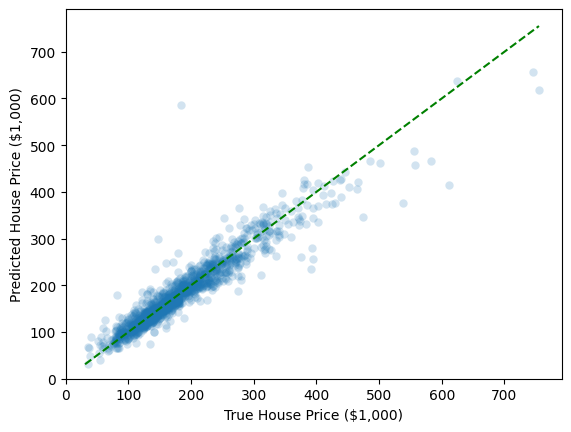

In [8]:
# To evaluate, we can get the average performance over a cross validation
best_estimator = gs.best_estimator_
training_pred = cross_val_predict(
    GradientBoostingRegressor(**gs.best_params_),
    training,
    training_prices,
    cv=5,
    n_jobs=1
)

# A more intuitive meaningful metric than the RMSE of log difference is correlation.
# The Pearson coefficient of ~90%, which is great performance for a small model with no hand-crafted features.
# That translates to ~90% of the sale price variance can be explained by this model.
print("Validation Coefficient of Determination:", r2_score(training_prices, training_pred))

# Plot the true vs predicted sale price on the validation data
plt.figure("true_vs_pred")
plt.scatter(training_prices/1000, training_pred/1000, alpha=0.2, linewidths=0)
plt.xlabel("True House Price ($1,000)")
plt.ylabel("Predicted House Price ($1,000)")
one2one = np.array([min(min(training_prices), min(training_pred)),
                    max(max(training_prices), max(training_pred))])/1000
plt.plot(one2one, one2one, c='g', linestyle="--")
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.show()
if SAVE_VIS:
    plt.savefig(
        os.path.join(SAVE_DIR, "house_price_validation_performance.png"),
        bbox_inches="tight"
    )
plt.close("true_vs_pred")

In [9]:
# For the test data, we can't remove entries. Only modified the data similarly to how we did for the input data. For
#   entries that can't be removed, we can set them to the average, or the most common value
test = pd.DataFrame(pd.read_csv(PATH_TO_HOUSE_TEST))
test = house_data_fill_in(test)
test = house_data_convert_types(test)

# Get the prices of the testing data houses
test_prices = best_estimator.predict(test)

# Output the results in the format accepted by Kaggle
output = pd.DataFrame({"Id": range(1461, 2920), "SalePrice": test_prices})
if CREATE_OUTPUT_FILE:
    output.to_csv(
        os.path.join(SAVE_DIR, "house_price_submission.csv"),
        index=False
    )